# Exemples d'utilisation de modèles simplifiés RC

<div style="text-align: right"> André Mounier </div>

---
Étude de l'effet sur les estimations de consommations annuelles

**Importation des modules**

In [1]:
import os 
import numpy as np
import tqdm
from datetime import date
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

In [2]:
today = pd.Timestamp(date.today()).strftime('%Y%m%d')

output = 'output'
folder = '{}_RC_models'.format(today)
figs_folder = os.path.join(output, folder, 'figs')

if folder not in os.listdir(output):
    os.mkdir(os.path.join(output,folder))
if 'figs' not in os.listdir(os.path.join(output, folder)):
    os.mkdir(figs_folder)

## Définition de la température extérieure ($T_a$)

#### Valeurs historiques

Récupération de données historiques via l'API d'[Open-Météo](https://open-meteo.com) pour des [coordonnées](https://www.gps-longitude-latitude.net/longitude-latitude-coordonnees-gps-du-lieu) données.

In [3]:
def get_open_meteo_url(longitude, latitude, start_year, end_year, hourly_variables):
    """
    Récupération de l'url de l'API Open-Météo
    """
    if isinstance(hourly_variables, list):
        hourly_variables = ','.join(hourly_variables)
    url = 'https://archive-api.open-meteo.com/v1/archive?latitude={}&longitude={}&start_date={}-01-01&end_date={}-12-31&hourly={}&timezone=Europe%2FBerlin'.format(latitude,longitude,start_year,end_year,hourly_variables)
    return url


def open_meteo_historical_data(longitude, latitude, start_year, end_year, hourly_variables, force=False):
    """
    Ouverture des fichiers meteo
    """
    if isinstance(hourly_variables, list):
        hourly_variables_str = ','.join(hourly_variables)
    else:
        hourly_variables_str = hourly_variables
        
    save_path = os.path.join('data','Open-Meteo')
    save_name = '{}_{}_{}_{}_{}.csv'.format(hourly_variables_str, start_year, end_year, longitude, latitude)
    save_name_units = '{}_{}_{}_{}_{}_units.txt'.format(hourly_variables_str, start_year, end_year, longitude, latitude)

    if save_name not in os.listdir(save_path) or force:
        url = get_open_meteo_url(longitude, latitude, start_year, end_year, hourly_variables)
        response = requests.get(url)
        json_data = response.json()

        units = json_data.get('hourly_units')
        with open(os.path.join(save_path,save_name_units), 'w') as f:
            for col, unit in units.items():
                f.write('{} : {} \n'.format(col,unit))
        
        data = pd.DataFrame().from_dict(json_data.get('hourly'))
        data.to_csv(os.path.join(save_path,save_name), index=False)
        
    data = pd.read_csv(os.path.join(save_path,save_name))
    data = data.set_index('time')
    data.index = pd.to_datetime(data.index)
    return data

In [4]:
coordinates_dict = {'Paris':(2.352222, 48.856614),
                    'Marseille':(5.369780, 43.296482)
                   }

In [5]:
longitude, latitude = coordinates_dict.get('Marseille')
start_year, end_year = 2000, 2020
hourly_variables = 'temperature_2m'

In [6]:
temperature_data = open_meteo_historical_data(longitude, latitude, start_year, end_year, hourly_variables)
temperature_data.head()

,temperature_2m
time,
2000-01-01 00:00:00,0.9
2000-01-01 01:00:00,0.6
2000-01-01 02:00:00,0.4
2000-01-01 03:00:00,0.1
2000-01-01 04:00:00,-0.1


#### Approximations sinusoïdales

La température extérieure peut être vue comme constante sommée à une double sinusoïdale, d'une période journalière et annuelle :
$$
T_a(t) = \mu_y + \delta_y \sin\left(\frac{2\pi}{T_y}t + \phi_y \right) + \delta_d \sin\left(\frac{2\pi}{T_d}t + \phi_d \right)
$$
On utilise les données historiques pour obtenir les différents paramètres.
**C'est faux pour les variations journalières, à modifier**

In [7]:
month_day_hourly_data = pd.DataFrame(index=pd.date_range('2000-01-01', '2000-12-31', freq='h'))
month_day_hourly_data.index = month_day_hourly_data.index.strftime('%m-%d %H:%M:%S')

years = list(range(start_year, end_year+1))

for y in tqdm.tqdm(years):
    temperature_data_year = temperature_data[temperature_data.index.year==y]
    temperature_data_year = temperature_data_year.rename(columns={'temperature_2m':y})
    temperature_data_year.index = temperature_data_year.index.strftime('%m-%d %H:%M:%S')
    
    month_day_hourly_data = month_day_hourly_data.join(temperature_data_year,how='left')
month_day_hourly_data.index = [pd.to_datetime('2000-{}'.format(t)) for t in month_day_hourly_data.index]
month_day_hourly_data.head()

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 50.76it/s]


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2000-01-01 00:00:00,0.9,3.1,1.0,9.3,3.2,3.5,7.7,7.1,1.8,9.1,...,6.6,10.9,8.9,8.7,4.9,10.5,3.7,12.3,5.0,6.7
2000-01-01 01:00:00,0.6,1.3,0.2,9.1,2.9,3.3,8.1,7.2,0.9,8.6,...,6.1,10.7,8.7,8.2,5.1,10.3,3.5,11.8,8.0,5.8
2000-01-01 02:00:00,0.4,0.6,-0.2,8.8,2.5,3.0,8.1,7.4,0.4,8.5,...,6.0,10.5,9.0,8.2,5.1,10.0,6.9,11.2,10.3,7.3
2000-01-01 03:00:00,0.1,0.8,-0.7,8.4,2.3,3.0,8.0,7.6,0.1,8.2,...,5.8,10.2,9.3,7.8,4.7,9.9,6.2,11.2,11.0,5.2
2000-01-01 04:00:00,-0.1,1.0,-1.2,8.3,1.9,2.9,7.9,7.7,-0.2,7.9,...,5.8,10.0,9.6,7.4,4.6,9.6,5.4,10.8,9.0,5.3


En commençant par l'amplitude annuelle.

In [8]:
if False:
    month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    for i,y in enumerate(years):
        label = None
        if i==0:
            label='Moyennes journalières ({}-{})'.format(years[0],years[-1])
        ax.plot(month_day_daily_data[y],color='k',alpha=0.07, label=label)
    ax.plot(month_day_daily_data.mean(axis=1),label='Moyenne',color='k')
    ax.legend()
    ax.set_xlim([pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31')])
    ax.set_ylabel('Température extérieure (°C)')
    myFmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_formatter(myFmt)
    
    plt.savefig(os.path.join(figs_folder,'mean_daily_temperature_timeserie.png'),bbox_inches='tight')
    plt.show()

def annual_temperature_variation(t,mu_y=20, delta_y=10, phi_y=0):
    """
    Variations de températures annuelles au pas de temps horaire
    """
    t_hour = (t- t[0]).days*24 + (t- t[0]).seconds/3600
    T_hour = 24*365
    
    temperature = mu_y + delta_y * np.sin(2*np.pi*t_hour/T_hour+phi_y)
    return temperature

# on utilise les miyennes journalières et non pas horaires (réduction du bruit)
month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()

# moyenne des 20 années de données (2000-2020)
mean_daily = month_day_daily_data[years].mean(axis=1)

# moyenne glissante sur 10 jours pour lisser le fit de la sinusoide
mean_daily = mean_daily.rolling(10,center=True).mean()

# défintion des paramètres de la sinusoidale annuelle 
mu_y = (mean_daily.max() + mean_daily.min())/2
delta_y = mean_daily.max() - mu_y

shift_list = np.linspace(0,2*np.pi,100)
corr_list = []
for shift in tqdm.tqdm(shift_list):
    month_day_hourly_data['model_annual_temperature'] = annual_temperature_variation(month_day_hourly_data.index,mu_y,delta_y,phi_y=shift)

    month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()
    
    corr = r2_score(month_day_daily_data[years].mean(axis=1), month_day_daily_data['model_annual_temperature'])
    corr_list.append(corr)
phi_y = shift_list[corr_list.index(max(corr_list))]

# calcul des variations de températures annuelles
month_day_hourly_data['model_annual_temperature'] = annual_temperature_variation(month_day_hourly_data.index,mu_y,delta_y,phi_y=phi_y)

if False:
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    ax.plot(shift_list,corr_list,label='Corrélation max : {:.1f} rad'.format(phi_y))
    ax.set_xlabel('Déphasage (rad)')
    ax.set_ylabel('Corrélation (R$^2$)')
    ax.legend()
    ax.set_ylim([0,1])
    plt.savefig(os.path.join(figs_folder,'mean_daily_temperature_sinewave_corr.png'),bbox_inches='tight')
    plt.show()

if False:
    month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    corr = r2_score(month_day_daily_data[years].mean(axis=1), month_day_daily_data['model_annual_temperature'])
    label= 'R$^2$ = {:.2f}'.format(corr)
    ax.plot(month_day_daily_data['model_annual_temperature'],month_day_daily_data[years].mean(axis=1),color='k',ls='',marker='o',alpha=0.05,label=label)
    ax.legend()
    ax.set_xlabel('Température extérieure modélisée (°C)')
    ax.set_ylabel('Température extérieure observée (°C)')
    diag = [0,month_day_hourly_data.max().max()]
    ax.plot(diag,diag, color='k')
    ax.set_ylim(diag)
    ax.set_xlim(diag)
    plt.savefig(os.path.join(figs_folder,'mean_daily_temperature_sinewave_versus.png'),bbox_inches='tight')
    plt.show()
    
if False:
    month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    ax.plot(month_day_daily_data[years].mean(axis=1),label='Observations (moyenne journalière)',color='k')
    ax.fill_between(month_day_daily_data[years].index, 
                    month_day_daily_data[years].mean(axis=1)+month_day_daily_data[years].std(axis=1),
                    month_day_daily_data[years].mean(axis=1)-month_day_daily_data[years].std(axis=1),color='lightgrey',zorder=-1)
    ax.plot(month_day_daily_data['model_annual_temperature'],label='Modélisation sinusoïdale',color='tab:blue')
    ax.legend()
    ax.set_xlim([pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31')])
    ax.set_ylabel('Température extérieure (°C)')
    myFmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_formatter(myFmt)
    
    plt.savefig(os.path.join(figs_folder,'mean_daily_temperature_sinewave_timeserie.png'),bbox_inches='tight')
    plt.show()

month_day_hourly_data.head()

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 474.65it/s]


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,model_annual_temperature
2000-01-01 00:00:00,0.9,3.1,1.0,9.3,3.2,3.5,7.7,7.1,1.8,9.1,...,10.9,8.9,8.7,4.9,10.5,3.7,12.3,5.0,6.7,7.590450
2000-01-01 01:00:00,0.6,1.3,0.2,9.1,2.9,3.3,8.1,7.2,0.9,8.6,...,10.7,8.7,8.2,5.1,10.3,3.5,11.8,8.0,5.8,7.587861
2000-01-01 02:00:00,0.4,0.6,-0.2,8.8,2.5,3.0,8.1,7.4,0.4,8.5,...,10.5,9.0,8.2,5.1,10.0,6.9,11.2,10.3,7.3,7.585277
2000-01-01 03:00:00,0.1,0.8,-0.7,8.4,2.3,3.0,8.0,7.6,0.1,8.2,...,10.2,9.3,7.8,4.7,9.9,6.2,11.2,11.0,5.2,7.582697
2000-01-01 04:00:00,-0.1,1.0,-1.2,8.3,1.9,2.9,7.9,7.7,-0.2,7.9,...,10.0,9.6,7.4,4.6,9.6,5.4,10.8,9.0,5.3,7.580122


Modélisation des variations intrajournalières. Pour éviter d'avoir trop de journées, j'utilise uniquement l'année 2020. 

In [9]:
prep_hour_hourly_data = pd.DataFrame(month_day_hourly_data[list(range(2000,2021))].mean(axis=1)).rename(columns={0:'mean_value'})
prep_hour_hourly_data['hour'] = prep_hour_hourly_data.index.hour
prep_hour_hourly_data['month'] = prep_hour_hourly_data.index.month
hour_hourly_data = prep_hour_hourly_data.groupby(['month','hour']).mean()
hour_hourly_data = hour_hourly_data.reset_index()

def get_second_order_daily_temperature_parameters(data):
    """
    Obtention des paramètres de modélisation des variations de températures journalières.
    """
    t = data.index.values
    res = np.zeros(t.shape)

    K_day = data.mean_value.max()
    K_night = data.mean_value.min()

    warming_period_start_hour = data.mean_value.idxmin()%24
    cooling_period_start_hour = data.mean_value.idxmax()%24
    tau = (cooling_period_start_hour - warming_period_start_hour)/4.5
    
    warming_period = (t%24>=warming_period_start_hour)&(t%24<=cooling_period_start_hour)
    cooling_period = (t%24>=cooling_period_start_hour)|(t%24<=warming_period_start_hour)
    intersection_period = (warming_period) & (cooling_period)
    
    def temperature_warming_period(t,Kmax,Kmin,tau):
        tp = t%24-warming_period_start_hour
        return Kmin + (Kmax-Kmin)*(1-np.exp(-tp/tau))*(1-np.exp(-tp/tau))

    def temperature_cooling_period(t,Kmax,Kmin,tau):
        tp = t%24-cooling_period_start_hour
        tp[tp < 0] += 24
        return Kmax - (Kmax-Kmin)*(1-np.exp(-tp/tau))*(1-np.exp(-tp/tau))

    p0_warming = (K_day,K_night,tau)
    popt_warming, _ = curve_fit(temperature_warming_period, t[warming_period], data.mean_value.values[warming_period], p0=p0_warming, method='lm')
    p0_cooling = (K_day,K_night,tau)
    popt_cooling, _ = curve_fit(temperature_cooling_period, t[cooling_period], data.mean_value.values[cooling_period], p0=p0_cooling, method='lm')
    
    #res[cooling_period] = temperature_cooling_period(t[cooling_period],*popt_cooling)
    #res[warming_period] = temperature_warming_period(t[warming_period],*popt_warming)
    #res[intersection_period] = (temperature_warming_period(t[intersection_period],*popt_warming) + temperature_cooling_period(t[intersection_period],*popt_cooling))/2

    parameters = {'warming':(warming_period_start_hour,*popt_warming),
                  'cooling':(cooling_period_start_hour,*popt_cooling),
                 }
    return parameters

daily_profile_parameters = dict()
for month in range(1,13):
    plot_hour_hourly_data = hour_hourly_data[hour_hourly_data.month==month].copy()
    plot_hour_hourly_data.mean_value = plot_hour_hourly_data.mean_value - plot_hour_hourly_data.mean_value.mean()
    more_hour = list(range(24,100))
    more_hour_df = pd.DataFrame().from_dict({'month':[month]*len(more_hour),'hour':more_hour, 'mean_value':[plot_hour_hourly_data[plot_hour_hourly_data.hour==h%24].mean_value.values[0] for h in more_hour]})
    plot_hour_hourly_data = pd.concat([plot_hour_hourly_data, more_hour_df])

    params = get_second_order_daily_temperature_parameters(plot_hour_hourly_data)
    daily_profile_parameters[month] = params

daily_profile_parameters.get(1)

{'warming': (np.int64(8),
  np.float64(5.870630691722853),
  np.float64(-2.7096681646962124),
  np.float64(3.6607951343622203)),
 'cooling': (np.int64(16),
  np.float64(3.612920270549295),
  np.float64(-2.2151895012018694),
  np.float64(3.3211858161740926))}

In [10]:
def get_second_order_daily_temperature(t,parameters_dict):
    """
    Modélisation simplifiée des variations de températures journalières. 
    """
    def temperature_warming_period(t,warming_period_start_hour,Kmax,Kmin,tau):
        tp = t%24-warming_period_start_hour
        return Kmin + (Kmax-Kmin)*(1-np.exp(-tp/tau))*(1-np.exp(-tp/tau))

    def temperature_cooling_period(t,cooling_period_start_hour,Kmax,Kmin,tau):
        tp = t%24-cooling_period_start_hour
        if tp < 0:
            tp += 24
        return Kmax - (Kmax-Kmin)*(1-np.exp(-tp/tau))*(1-np.exp(-tp/tau))
        
    res = [np.nan]*len(t)
    for i,date in enumerate(t):
        date = pd.Timestamp(date)
        h = date.hour
        parameters = parameters_dict.get(date.month)
        param_warming = parameters.get('warming')
        param_cooling = parameters.get('cooling')

        warming_period = (h%24>=param_warming[0])&(h%24<=param_cooling[0])
        cooling_period = (h%24>=param_cooling[0])|(h%24<=param_warming[0])
        intersection_period = (warming_period) & (cooling_period)

        if intersection_period:
            res[i] = (temperature_warming_period(h,*param_warming) + temperature_cooling_period(h,*param_cooling))/2
        elif warming_period:
            res[i] = temperature_warming_period(h,*param_warming)
        else:
            res[i] = temperature_cooling_period(h,*param_cooling)
    return res

month_day_hourly_data['model_daily_temperature'] = get_second_order_daily_temperature(month_day_hourly_data.index.values,daily_profile_parameters)
month_day_hourly_data['model_temperature'] = month_day_hourly_data['model_annual_temperature'] + month_day_hourly_data['model_daily_temperature']
month_day_hourly_data.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2014,2015,2016,2017,2018,2019,2020,model_annual_temperature,model_daily_temperature,model_temperature
2000-01-01 00:00:00,0.9,3.1,1.0,9.3,3.2,3.5,7.7,7.1,1.8,9.1,...,8.7,4.9,10.5,3.7,12.3,5.0,6.7,7.590450,-1.214132,6.376318
2000-01-01 01:00:00,0.6,1.3,0.2,9.1,2.9,3.3,8.1,7.2,0.9,8.6,...,8.2,5.1,10.3,3.5,11.8,8.0,5.8,7.587861,-1.465334,6.122528
2000-01-01 02:00:00,0.4,0.6,-0.2,8.8,2.5,3.0,8.1,7.4,0.4,8.5,...,8.2,5.1,10.0,6.9,11.2,10.3,7.3,7.585277,-1.655326,5.929951
2000-01-01 03:00:00,0.1,0.8,-0.7,8.4,2.3,3.0,8.0,7.6,0.1,8.2,...,7.8,4.7,9.9,6.2,11.2,11.0,5.2,7.582697,-1.798168,5.784529
2000-01-01 04:00:00,-0.1,1.0,-1.2,8.3,1.9,2.9,7.9,7.7,-0.2,7.9,...,7.4,4.6,9.6,5.4,10.8,9.0,5.3,7.580122,-1.905102,5.675019


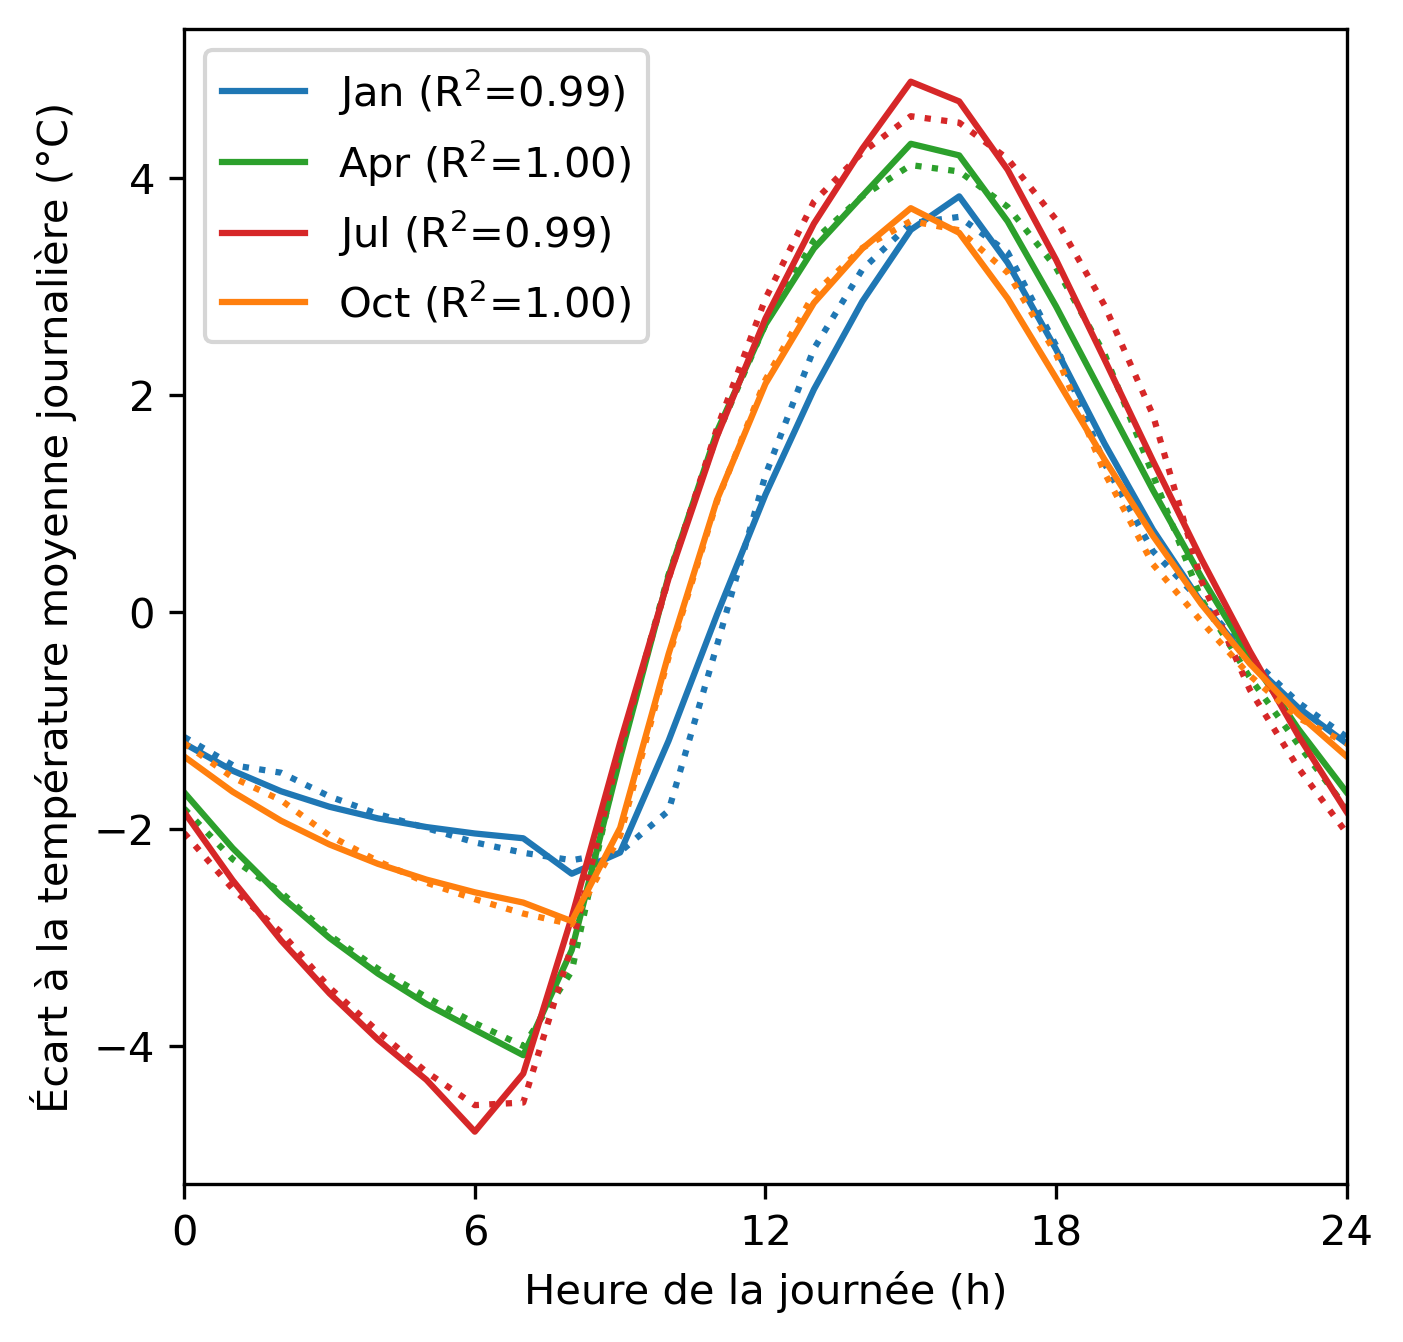

In [11]:
if True:
    days = 1
    intervals = 6
    
    fig,ax = plt.subplots(dpi=300,figsize=(5*days,5))
    month_season_dict = {1:'DJF',2:'DJF',3:'MAM',4:'MAM',5:'MAM',6:'JJA',7:'JJA',8:'JJA',9:'SON',10:'SON',11:'SON',12:'DJF'}
    season_color_dict = {'DJF':'tab:blue','MAM':'tab:green','JJA':'tab:red','SON':'tab:orange'}
    for month in range(1,13):
        plot_hour_hourly_data = hour_hourly_data[hour_hourly_data.month==month].copy()
        plot_hour_hourly_data.mean_value = plot_hour_hourly_data.mean_value - plot_hour_hourly_data.mean_value.mean()
        more_hour = list(range(24,100))
        more_hour_df = pd.DataFrame().from_dict({'month':[month]*len(more_hour),'hour':more_hour, 'mean_value':[plot_hour_hourly_data[plot_hour_hourly_data.hour==h%24].mean_value.values[0] for h in more_hour]})
        plot_hour_hourly_data = pd.concat([plot_hour_hourly_data, more_hour_df])
        if month in [1,4,7,10]:#list(range(1,13)):
            month_name = pd.to_datetime('2000-{}-01'.format(month)).strftime('%b')
            ax.plot(plot_hour_hourly_data.hour,plot_hour_hourly_data.mean_value,color=season_color_dict.get(month_season_dict.get(month)),ls=':')
            model = get_second_order_daily_temperature([pd.to_datetime('2000-{}-01 {}:00:00'.format(month, h%24)) for h in plot_hour_hourly_data.hour], daily_profile_parameters)
            corr = r2_score(plot_hour_hourly_data.mean_value, model)
            ax.plot(plot_hour_hourly_data.hour,model,color=season_color_dict.get(month_season_dict.get(month)),label='{} (R$^2$={:.2f})'.format(month_name, corr))
    ax.set_xlim([0,24*days])
    ax.set_xticks(list(range(0,24*days+1,intervals)), [x%24 if x!= 24 else x for x in list(range(0,24*days+1,intervals))])
    ax.legend()
    # ax.grid()
    ax.set_xlabel('Heure de la journée (h)')
    ax.set_ylabel('Écart à la température moyenne journalière (°C)')
    
    plt.savefig(os.path.join(figs_folder,'daily_temperature_2nd_order_fit_timeserie.png'),bbox_inches='tight')
    plt.show()

## Définition des apports solaires ($\Phi_s$)

In [12]:
solar_data = open_meteo_historical_data(longitude, latitude, start_year, end_year, 'direct_radiation_instant')
solar_data.head()

,direct_radiation_instant
time,
2000-01-01 00:00:00,0.0
2000-01-01 01:00:00,0.0
2000-01-01 02:00:00,0.0
2000-01-01 03:00:00,0.0
2000-01-01 04:00:00,0.0


In [13]:
month_day_hourly_solar_data = pd.DataFrame(index=pd.date_range('2000-01-01', '2000-12-31', freq='h'))
month_day_hourly_solar_data.index = month_day_hourly_solar_data.index.strftime('%m-%d %H:%M:%S')

years = list(range(start_year, end_year+1))

for y in tqdm.tqdm(years):
    solar_data_year = solar_data[solar_data.index.year==y]
    solar_data_year = solar_data_year.rename(columns={'direct_radiation_instant':y})
    solar_data_year.index = solar_data_year.index.strftime('%m-%d %H:%M:%S')
    
    month_day_hourly_solar_data = month_day_hourly_solar_data.join(solar_data_year,how='left')
month_day_hourly_solar_data.index = [pd.to_datetime('2000-{}'.format(t)) for t in month_day_hourly_solar_data.index]
month_day_hourly_solar_data.head()

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 51.41it/s]


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2000-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
if False:
    month_day_daily_solar_data = month_day_hourly_solar_data.groupby(pd.Grouper(freq='1D')).max()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    for i,y in enumerate(years):
        label = None
        if i==0:
            label='Maximums journaliers ({}-{})'.format(years[0],years[-1])
        ax.plot(month_day_daily_solar_data[y],color='k',alpha=0.07, label=label)
    ax.plot(month_day_daily_solar_data.mean(axis=1),label='Moyenne',color='k')
    ax.legend()
    ax.set_xlim([pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31')])
    ax.set_ylabel('Irradiance (W.m$^{-2}$)')
    myFmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_formatter(myFmt)
    
    plt.savefig(os.path.join(figs_folder,'max_daily_solar_irradiance_timeserie.png'),bbox_inches='tight')
    plt.show()


def annual_irradiance_variation(t,mu_y=20, delta_y=10, phi_y=0):
    """
    Variations d'irradiance solaire annuelle au pas de temps horaire
    """
    t_hour = (t- t[0]).days*24 + (t- t[0]).seconds/3600
    T_hour = 24*365
    
    irr = mu_y + delta_y * np.sin(2*np.pi*t_hour/T_hour+phi_y)
    return irr

# on utilise les miyennes journalières et non pas horaires (réduction du bruit)
month_day_daily_solar_data = month_day_hourly_solar_data.groupby(pd.Grouper(freq='1D')).max()

# moyenne des 20 années de données (2000-2020)
mean_daily_solar = month_day_daily_solar_data[years].mean(axis=1)

# moyenne glissante sur 10 jours pour lisser le fit de la sinusoide
mean_daily_solar = mean_daily_solar.rolling(10,center=True).mean()

# défintion des paramètres de la sinusoidale annuelle 
mu_y_solar = (mean_daily_solar.max() + mean_daily_solar.min())/2
delta_y_solar = mean_daily_solar.max() - mu_y_solar

shift_list = np.linspace(0,2*np.pi,100)
corr_list_solar = []
for shift in tqdm.tqdm(shift_list):
    month_day_hourly_solar_data['model_annual_irradiance'] = annual_irradiance_variation(month_day_hourly_solar_data.index,mu_y_solar,delta_y_solar,phi_y=shift)
    month_day_daily_solar_data = month_day_hourly_solar_data.groupby(pd.Grouper(freq='1D')).max()
    
    corr = r2_score(month_day_daily_solar_data[years].mean(axis=1), month_day_daily_solar_data['model_annual_irradiance'])
    corr_list_solar.append(corr)
phi_y_solar = shift_list[corr_list_solar.index(max(corr_list_solar))]

# calcul des variations de températures annuelles
month_day_hourly_solar_data['model_annual_irradiance'] = annual_irradiance_variation(month_day_hourly_solar_data.index,mu_y_solar,delta_y_solar,phi_y=phi_y_solar)

if False:
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    ax.plot(shift_list,corr_list_solar,label='Corrélation max : {:.1f} rad'.format(phi_y_solar))
    ax.set_xlabel('Déphasage (rad)')
    ax.set_ylabel('Corrélation (R$^2$)')
    ax.legend()
    ax.set_ylim([0,1])
    plt.savefig(os.path.join(figs_folder,'max_daily_solar_irradiance_sinewave_corr.png'),bbox_inches='tight')
    plt.show()

if False:
    month_day_daily_solar_data = month_day_hourly_solar_data.groupby(pd.Grouper(freq='1D')).max()
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    corr = r2_score(month_day_daily_solar_data[years].mean(axis=1), month_day_daily_solar_data['model_annual_irradiance'])
    label= 'R$^2$ = {:.2f}'.format(corr)
    ax.plot(month_day_daily_solar_data['model_annual_irradiance'],month_day_daily_solar_data[years].mean(axis=1),color='k',ls='',marker='o',alpha=0.05,label=label)
    ax.legend()
    ax.set_xlabel('Irradiance modélisée (W.m$^{-2}$)')
    ax.set_ylabel('Irradiance observée (W.m$^{-2}$)')
    diag = [0,month_day_hourly_solar_data.max().max()]
    ax.plot(diag,diag, color='k')
    ax.set_ylim(diag)
    ax.set_xlim(diag)
    plt.savefig(os.path.join(figs_folder,'max_daily_solar_irradiance_sinewave_versus.png'),bbox_inches='tight')
    plt.show()
    
if False:
    month_day_daily_solar_data = month_day_hourly_solar_data.groupby(pd.Grouper(freq='1D')).max()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    ax.plot(month_day_daily_solar_data[years].mean(axis=1),label='Observations (moyenne journalière)',color='k')
    ax.fill_between(month_day_daily_solar_data[years].index, 
                    month_day_daily_solar_data[years].mean(axis=1)+month_day_daily_solar_data[years].std(axis=1),
                    month_day_daily_solar_data[years].mean(axis=1)-month_day_daily_solar_data[years].std(axis=1),color='lightgrey',zorder=-1)
    ax.plot(month_day_daily_solar_data['model_annual_irradiance'],label='Modélisation sinusoïdale',color='tab:blue')
    ax.legend()
    ax.set_xlim([pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31')])
    ax.set_ylabel('Irradiance (W.m$^{-2}$)')
    myFmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_formatter(myFmt)
    
    plt.savefig(os.path.join(figs_folder,'max_daily_solar_irradiance_sinewave_timeserie.png'),bbox_inches='tight')
    plt.show()

month_day_hourly_solar_data.head()

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 444.60it/s]


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,model_annual_irradiance
2000-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,197.532579
2000-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,197.554679
2000-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,197.576921
2000-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,197.599304
2000-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,197.621829


In [ ]:
prep_hour_hourly_solar_data = pd.DataFrame(month_day_hourly_solar_data[list(range(2000,2021))].mean(axis=1)).rename(columns={0:'mean_value'})
prep_hour_hourly_solar_data['hour'] = prep_hour_hourly_solar_data.index.hour
prep_hour_hourly_solar_data['month'] = prep_hour_hourly_solar_data.index.month
hour_hourly_solar_data = prep_hour_hourly_solar_data.groupby(['month','hour']).mean()
hour_hourly_solar_data = hour_hourly_solar_data.reset_index()

def get_irradiance_parameters(data):
    """
    Obtention des paramètres de modélisation des variations de températures journalières.
    """
    t = data.index.values
    res = np.zeros(t.shape)

    K_day = data.mean_value.max()
    K_night = data.mean_value.min()

    warming_period_start_hour = data.mean_value.idxmin()%24
    cooling_period_start_hour = data.mean_value.idxmax()%24
    tau = (cooling_period_start_hour - warming_period_start_hour)/4.5
    
    warming_period = (t%24>=warming_period_start_hour)&(t%24<=cooling_period_start_hour)
    cooling_period = (t%24>=cooling_period_start_hour)|(t%24<=warming_period_start_hour)
    intersection_period = (warming_period) & (cooling_period)
    
    def temperature_warming_period(t,Kmax,Kmin,tau):
        tp = t%24-warming_period_start_hour
        return Kmin + (Kmax-Kmin)*(1-np.exp(-tp/tau))*(1-np.exp(-tp/tau))

    def temperature_cooling_period(t,Kmax,Kmin,tau):
        tp = t%24-cooling_period_start_hour
        tp[tp < 0] += 24
        return Kmax - (Kmax-Kmin)*(1-np.exp(-tp/tau))*(1-np.exp(-tp/tau))

    p0_warming = (K_day,K_night,tau)
    popt_warming, _ = curve_fit(temperature_warming_period, t[warming_period], data.mean_value.values[warming_period], p0=p0_warming, method='lm')
    p0_cooling = (K_day,K_night,tau)
    popt_cooling, _ = curve_fit(temperature_cooling_period, t[cooling_period], data.mean_value.values[cooling_period], p0=p0_cooling, method='lm')

    parameters = {'warming':(warming_period_start_hour,*popt_warming),
                  'cooling':(cooling_period_start_hour,*popt_cooling),
                 }
    return parameters

daily_profile_parameters = dict()
for month in range(1,13):
    plot_hour_hourly_data = hour_hourly_data[hour_hourly_data.month==month].copy()
    plot_hour_hourly_data.mean_value = plot_hour_hourly_data.mean_value - plot_hour_hourly_data.mean_value.mean()
    more_hour = list(range(24,100))
    more_hour_df = pd.DataFrame().from_dict({'month':[month]*len(more_hour),'hour':more_hour, 'mean_value':[plot_hour_hourly_data[plot_hour_hourly_data.hour==h%24].mean_value.values[0] for h in more_hour]})
    plot_hour_hourly_data = pd.concat([plot_hour_hourly_data, more_hour_df])

    params = get_second_order_daily_temperature_parameters(plot_hour_hourly_data)
    daily_profile_parameters[month] = params

daily_profile_parameters.get(1)

/tmp/ipykernel_512135/2085380666.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


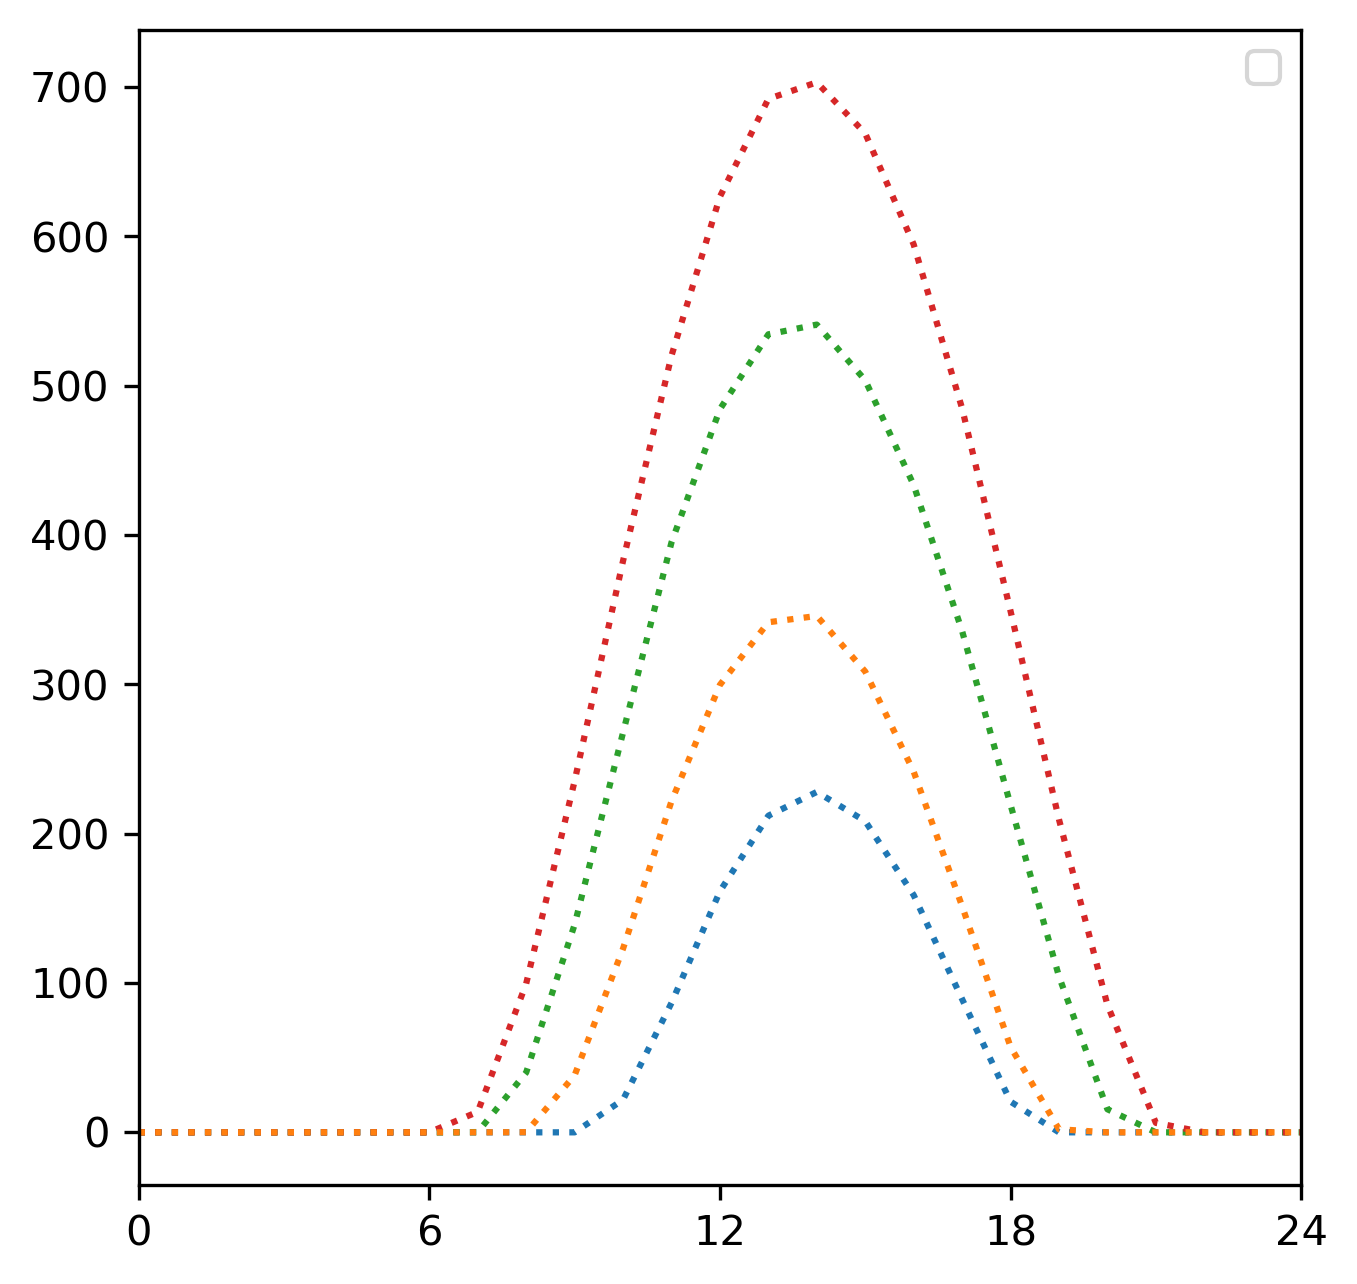

In [15]:
if True:
    days = 1
    intervals = 6
    
    fig,ax = plt.subplots(dpi=300,figsize=(5*days,5))
    month_season_dict = {1:'DJF',2:'DJF',3:'MAM',4:'MAM',5:'MAM',6:'JJA',7:'JJA',8:'JJA',9:'SON',10:'SON',11:'SON',12:'DJF'}
    season_color_dict = {'DJF':'tab:blue','MAM':'tab:green','JJA':'tab:red','SON':'tab:orange'}
    for month in range(1,13):
        plot_hour_hourly_data = hour_hourly_solar_data[hour_hourly_solar_data.month==month].copy()
        plot_hour_hourly_data.mean_value = plot_hour_hourly_data.mean_value #- plot_hour_hourly_data.mean_value.max()
        more_hour = list(range(24,100))
        more_hour_df = pd.DataFrame().from_dict({'month':[month]*len(more_hour),'hour':more_hour, 'mean_value':[plot_hour_hourly_data[plot_hour_hourly_data.hour==h%24].mean_value.values[0] for h in more_hour]})
        plot_hour_hourly_data = pd.concat([plot_hour_hourly_data, more_hour_df])
        if month in [1,4,7,10]:#list(range(1,13)):
            month_name = pd.to_datetime('2000-{}-01'.format(month)).strftime('%b')
            ax.plot(plot_hour_hourly_data.hour,plot_hour_hourly_data.mean_value,color=season_color_dict.get(month_season_dict.get(month)),ls=':')
            #model = get_second_order_daily_temperature([pd.to_datetime('2000-{}-01 {}:00:00'.format(month, h%24)) for h in plot_hour_hourly_data.hour], daily_profile_parameters)
            #corr = r2_score(plot_hour_hourly_data.mean_value, model)
            #ax.plot(plot_hour_hourly_data.hour,model,color=season_color_dict.get(month_season_dict.get(month)),label='{} (R$^2$={:.2f})'.format(month_name, corr))
    ax.set_xlim([0,24*days])
    ax.set_xticks(list(range(0,24*days+1,intervals)), [x%24 if x!= 24 else x for x in list(range(0,24*days+1,intervals))])
    ax.legend()
    # ax.grid()
    #ax.set_xlabel('Heure de la journée (h)')
    #ax.set_ylabel('Écart à la température moyenne journalière (°C)')
    
    #plt.savefig(os.path.join(figs_folder,'daily_temperature_2nd_order_fit_timeserie.png'),bbox_inches='tight')
    plt.show()